# Capstone Project 3: 
## Part III: Data Modeling, Model Optimizations, Predictions and Analysis of Results

In Part III of the project, we will use the modeling data saved at the end of Part II.

For modeling we will use data_a; we will create a target feature and will build and optimize a model using this data. Predictions will be made with the best model using the records Data (B) (unknown number of applicants) with ‘Time Posted’ of one day.

In [1]:
# Import relevant libraries and packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style = 'whitegrid', font_scale = 1.8)

In [2]:
# Ignore warnings

import warnings
warnings.filterwarnings('ignore')

In [3]:
# load saved data for modeling

data_a = pd.read_excel('data/jobs_ds_s1_s5_a_model.xlsx')
data_b = pd.read_excel('data/jobs_ds_s1_s5_b_model.xlsx')

In [4]:
data_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1513 entries, 0 to 1512
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Job Title             1513 non-null   object
 1   Industry              1513 non-null   object
 2   Job Function          1513 non-null   object
 3   Metro Area            1513 non-null   object
 4   Education-Bachelor    1513 non-null   int64 
 5   Education-Master      1513 non-null   int64 
 6   Education-Doctor      1513 non-null   int64 
 7   Seniority Level       1513 non-null   object
 8   Relevance             1513 non-null   int64 
 9   Time Posted           1513 non-null   int64 
 10  Number of Applicants  1513 non-null   int64 
dtypes: int64(6), object(5)
memory usage: 130.1+ KB


In [5]:
data_a.head()

,Job Title,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Seniority Level,Relevance,Time Posted,Number of Applicants
0,Data Scientist,Staffing and Recruiting,Engineering,ATL,0,1,1,entry,3,2,40
1,Data Scientist,Financial Services,Engineering,ATL,0,0,0,entry,2,1,25
2,Data Scientist,Financial Services,Engineering,ATL,0,1,0,entry,2,1,29
3,Data Scientist,Construction,Engineering,ATL,0,1,0,entry,3,2,27
4,Data Scientist,Internet,Engineering,ATL,0,0,0,entry,2,5,192


In [6]:
data_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3364 entries, 0 to 3363
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Job Title             3364 non-null   object
 1   Industry              3364 non-null   object
 2   Job Function          3364 non-null   object
 3   Metro Area            3364 non-null   object
 4   Education-Bachelor    3364 non-null   int64 
 5   Education-Master      3364 non-null   int64 
 6   Education-Doctor      3364 non-null   int64 
 7   Seniority Level       3364 non-null   object
 8   Relevance             3364 non-null   int64 
 9   Time Posted           3364 non-null   int64 
 10  Number of Applicants  3364 non-null   int64 
dtypes: int64(6), object(5)
memory usage: 289.2+ KB


In [7]:
data_b.head()

,Job Title,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Seniority Level,Relevance,Time Posted,Number of Applicants
0,Data Scientist,Staffing and Recruiting,Information Technology,ATL,1,1,0,entry,1,1,-10
1,Data Scientist,Research,Analyst,ATL,0,0,0,entry,2,1,-10
2,Data Scientist,Defense,Engineering,ATL,1,0,0,entry,3,1,-10
3,Data Scientist,Staffing and Recruiting,Information Technology,ATL,1,0,0,entry,2,1,-10
4,Data Scientist,Marketing and Advertising,Engineering,ATL,0,0,0,entry,3,1,-10


## III.1 Data Processing, Creating Target Feature, and Data Selection

Since we are interested in the postings with the smallest number of applicants, it is clear that for modeling we can use only Data A which has known 'Number of Applicants' values. In order to be able to adequately compare all postings, a new feature 'Applicants per Day' will be created.

- **Data Selection**

From Section II, we recall that there were several records in Data A with 'Time Posted' value of 0. Let's examine these records.

In [8]:
# check the number of records with 'Time Posted' values of 0
print('Number of records in Data A with Time Posted = 0: ', len(data_a[data_a['Time Posted'] == 0]))

Number of records in Data A with Time Posted = 0:  3


In [9]:
# display these records

data_a[data_a['Time Posted'] == 0]

,Job Title,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Seniority Level,Relevance,Time Posted,Number of Applicants
169,Machine Learning Engineer,Staffing and Recruiting,Research,DC,0,1,1,senior,4,0,161
588,Data Engineer,Internet,Engineering,CHI,1,1,0,associate,2,0,200
930,Data Engineer,Internet,Engineering,CHI,1,1,0,associate,2,0,200


There are only three out 1513 records with 'Time Posted' values of 0. All of these have a large number of applicants which makes them extreme outliers. Therefore, we can eliminate these records without losing essential information.

In [10]:
# eliminate the records with 'Time Posted' = 0 and create new data set data_1
data_a = data_a[data_a['Time Posted'] != 0]
data_a.reset_index(inplace = True, drop = True)
data_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1510 entries, 0 to 1509
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Job Title             1510 non-null   object
 1   Industry              1510 non-null   object
 2   Job Function          1510 non-null   object
 3   Metro Area            1510 non-null   object
 4   Education-Bachelor    1510 non-null   int64 
 5   Education-Master      1510 non-null   int64 
 6   Education-Doctor      1510 non-null   int64 
 7   Seniority Level       1510 non-null   object
 8   Relevance             1510 non-null   int64 
 9   Time Posted           1510 non-null   int64 
 10  Number of Applicants  1510 non-null   int64 
dtypes: int64(6), object(5)
memory usage: 129.9+ KB


Since we have eliminated the zero values in 'Time Posted', we can now create the new feature 'Applicants per Day'.

In [11]:
# create new feature 'Applicants per Day'
data_a['Applicants per Day'] = (data_a['Number of Applicants'] / data_a['Time Posted']).astype(int)
data_a.head(10)

,Job Title,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Seniority Level,Relevance,Time Posted,Number of Applicants,Applicants per Day
0,Data Scientist,Staffing and Recruiting,Engineering,ATL,0,1,1,entry,3,2,40,20
1,Data Scientist,Financial Services,Engineering,ATL,0,0,0,entry,2,1,25,25
2,Data Scientist,Financial Services,Engineering,ATL,0,1,0,entry,2,1,29,29
3,Data Scientist,Construction,Engineering,ATL,0,1,0,entry,3,2,27,13
4,Data Scientist,Internet,Engineering,ATL,0,0,0,entry,2,5,192,38
5,Data Scientist,Real Estate,Engineering,ATL,1,1,0,entry,4,3,86,28
6,Data Scientist,Banking,Engineering,ATL,0,1,0,entry,2,3,35,11
7,Data Scientist,Financial Services,Engineering,ATL,0,1,0,entry,2,2,37,18
8,Data Scientist,Financial Services,Engineering,ATL,0,1,1,entry,2,3,40,13
9,Data Scientist,Transportation,Science,AUS,1,1,1,entry,2,3,176,58


    - Examine the value count of 'Time Posted'

In [12]:
count_posted = data_a['Time Posted'].value_counts()
print(count_posted)

4    285
1    272
5    268
3    226
6    183
2    163
7    113
Name: Time Posted, dtype: int64


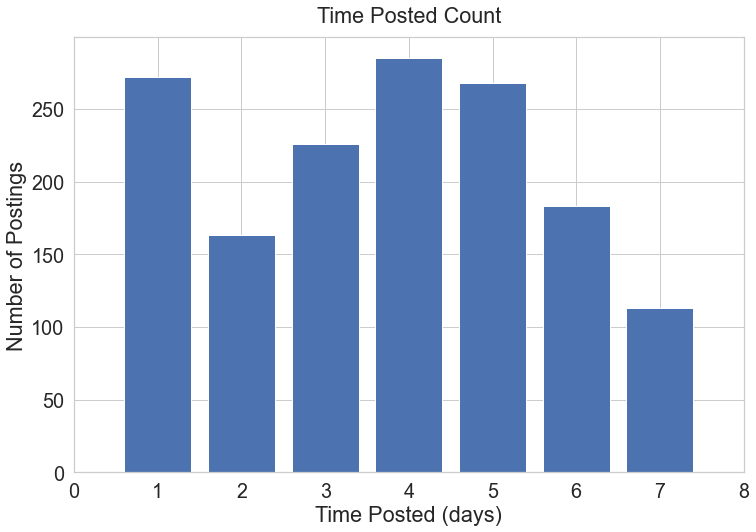

In [13]:
# visualize with a barplot

d_x = 1
x_min = 0
x_max = count_posted.index.max() + d_x
x_ticks = np.arange(x_min, x_max + d_x, d_x)


plt.figure(figsize = (12, 8))
plt.bar(count_posted.index, count_posted.values)
plt.xticks(x_ticks)
plt.xlabel('Time Posted (days)')
plt.ylabel('Number of Postings')
plt.title('Time Posted Count', pad = 15)

plt.show()

As evident from the plot, there is not one dominant 'Time Posted' value. We would like to determine next whether the 'Applicants per Day' distributions for different 'Time Posted' values are similar or are significantly different.

In [14]:
# define a function to plot the 'Applicants per Day' histogram for different 'Time Posted' values

feat_select = 'Time Posted'
val_select = 1

feat_hist = 'Applicants per Day'

bin_size = 5

# define function
def plot_hist_select(data, feat_select, val_select, feat_hist, bin_size):
    
    data_hist = data[data[feat_select] == val_select][feat_hist]
    n_bins = int((data_hist.max() - data_hist.min()) // bin_size) # make sure to define it as an integer
        
    plt.figure(figsize = (14, 10))
    plt.hist(data_hist, bins = n_bins)
    plt.xlim(0, 200)
    plt.xticks(np.arange(0, 240 , 20))
    plt.xlabel('Applicants per Day')
    plt.ylabel('Number of Postings')
    plt.title('Histogram of Applicants per Day: ' + feat_select + ' = ' + str(val_select), pad = 20)
    
    plt.show()

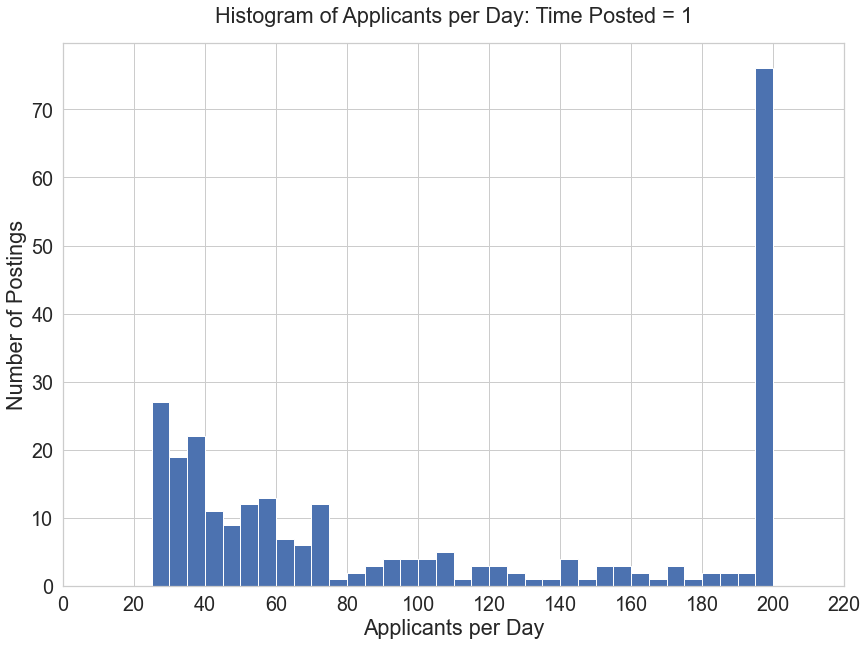

In [15]:
# Time Posted = 1
val_select = 1
bin_size = 5

plot_hist_select(data_a, feat_select, val_select, feat_hist, bin_size)

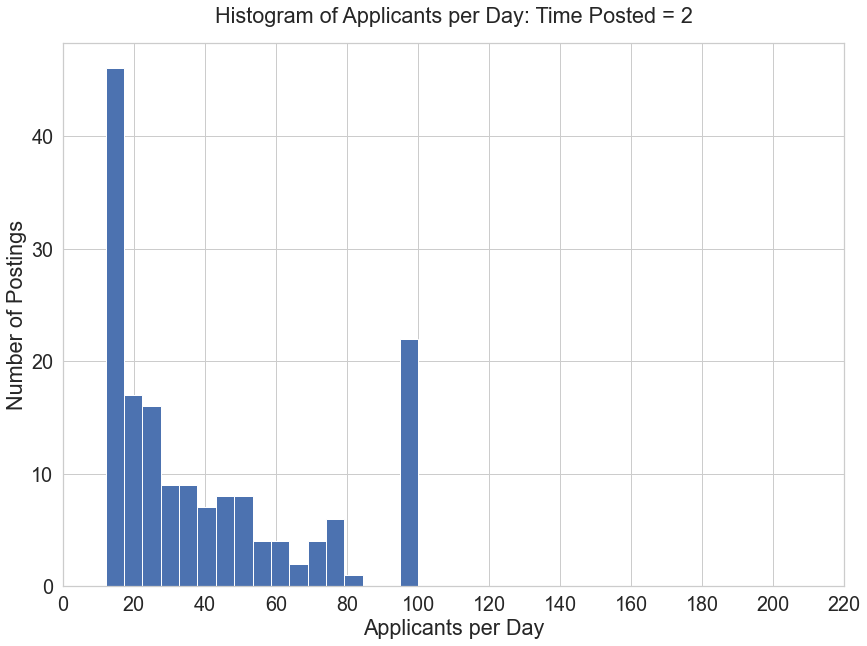

In [16]:
# Time Posted = 2
val_select = 2

plot_hist_select(data_a, feat_select, val_select, feat_hist, bin_size)

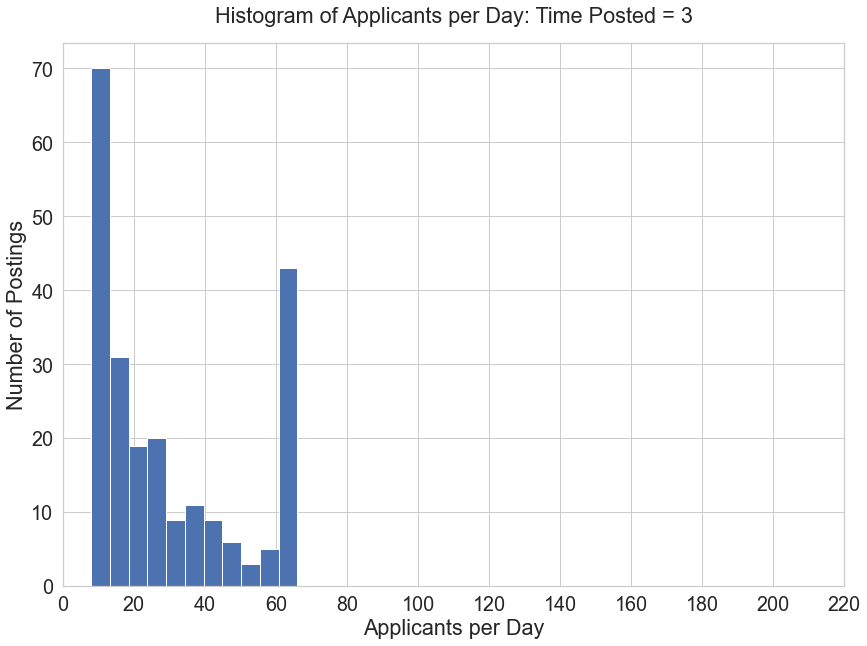

In [17]:
# Time Posted = 3
val_select = 3

plot_hist_select(data_a, feat_select, val_select, feat_hist, bin_size)

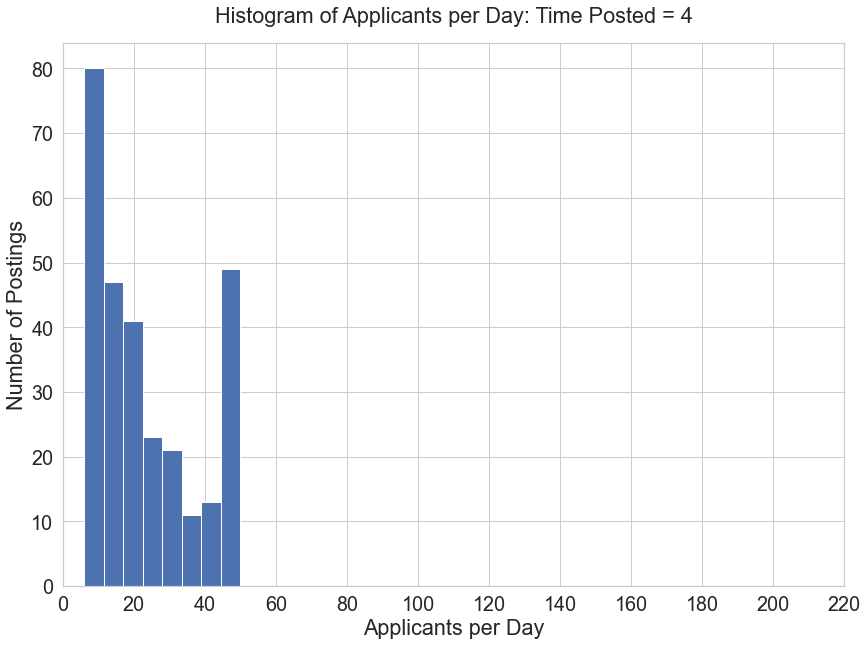

In [18]:
# Time Posted = 4
val_select = 4

plot_hist_select(data_a, feat_select, val_select, feat_hist, bin_size)

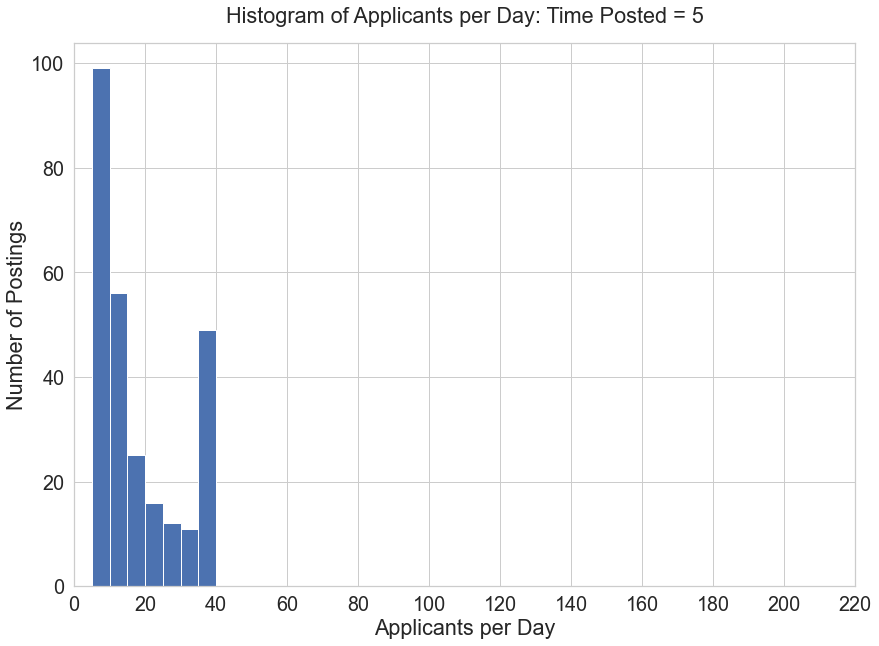

In [19]:
# Time Posted = 5
val_select = 5

plot_hist_select(data_a, feat_select, val_select, feat_hist, bin_size)

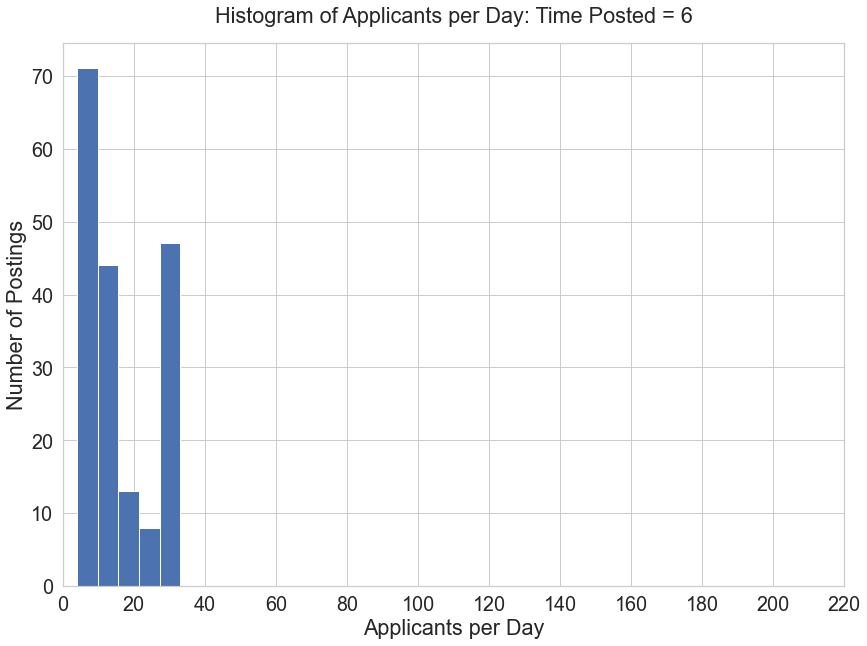

In [20]:
# Time Posted = 6
val_select = 6

plot_hist_select(data_a, feat_select, val_select, feat_hist, bin_size)

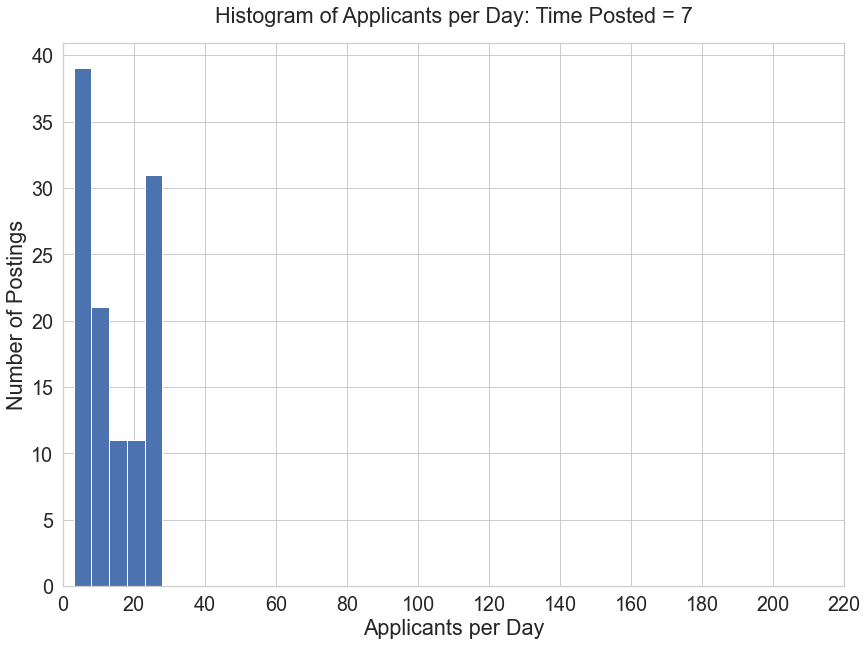

In [21]:
# Time Posted = 7
val_select = 7

plot_hist_select(data_a, feat_select, val_select, feat_hist, bin_size)

The histograms obtained show that the 'Applicants per Day' distributions vary significantly and systematically with the increase of the 'Time Posted'. It is therefore clear that for modeling one cannot treat the data with time posted of one in the same way as data with time posted of six or seven for example. 

The goal is to use data in the model which has the same target behavior. Although there are certain similarities in the histograms for some of the time posted values, we need a quantitative measure in order to determine the data subset with most similar target behavior. In order to achieve this, we will create and examine the 'Applicants per Day' Cumulative Distribution Functions (CDF) for different 'Time Posted' values.

In [22]:
# define function to plot CDFs

feat_select = 'Time Posted'

list_val_select = [1, 2, 3 , 4, 5, 6, 7]

feat_critical = 'Applicants per Day'

x_max = 75 # allow for chaging the axis limits
y_max = 90
legend_box_y = 0.8

c_alpha = 0.2

def plot_cdf(data, feat_select, list_val_select, feat_critical, x_max, y_max, legend_box_y, c_alpha):
    
    plt.figure(figsize = (14, 10))
    
    for item in list_val_select:
        
        p_below = []
        
        a_select = data[data[feat_select] == item][feat_critical]
        a_range = np.arange(a_select.min()+1, x_max+5, 1)
        
        for x in a_range:
            
            p_below.append(len(a_select[a_select <= x]) * 100 / len(a_select))
            
        plt.scatter(a_range, p_below, s = 100, alpha = c_alpha, label = feat_select + ' = ' + str(item))
        plt.legend(loc = 'center left', bbox_to_anchor = (1.0, legend_box_y))
        
    plt.ylim(0, y_max)
    plt.xlabel('Applicants per Day Threshold')
    plt.ylabel('Percentage of Data below Threshold')

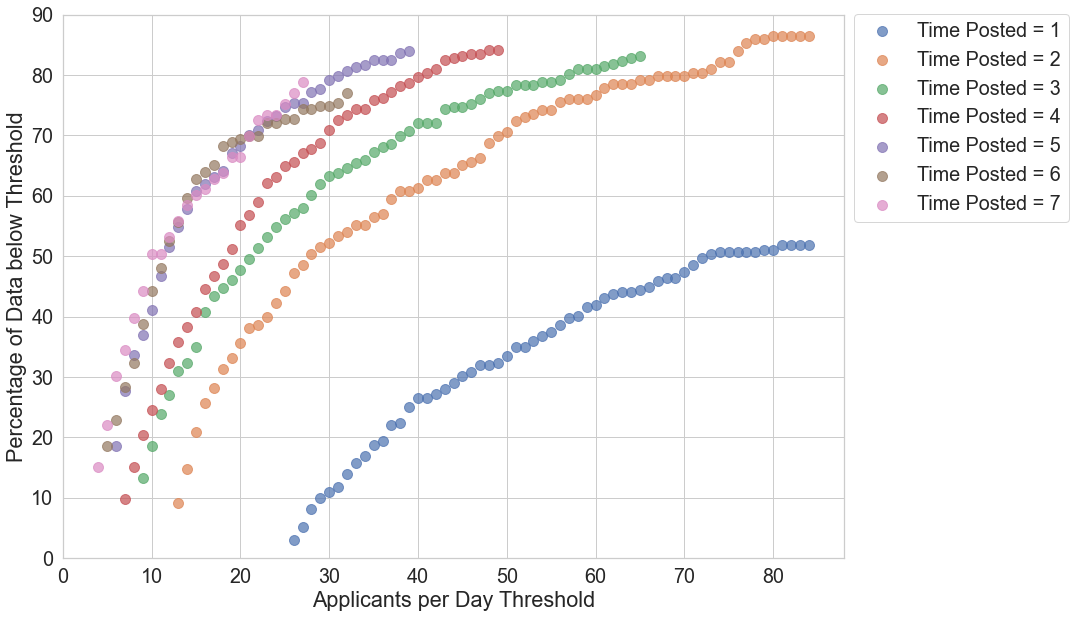

In [23]:
x_max = 80
legend_box_y = 0.81
c_alpha = 0.7

plot_cdf(data_a, feat_select, list_val_select, feat_critical, x_max, y_max, legend_box_y, c_alpha)

This is the most important result for the adequate selection of data to be used for modeling. 

The plot shows a clear trend in the behavior of 'Applicants per Day' as the time posted increases. Most applications occur during the first day of posting with a steady decrease of the number of applicants with each consecutive day. This is something one would normally expect. However, the plot clearly shows that the records with time posted of 5, 6, and 7 have the same behavior. Thus, these records will comprise the data subset to be used for modeling.

In [24]:
# select corresponding data and create new data set, data_m

list_posted = [5, 6, 7]

mask_posted = data_a['Time Posted'].isin(list_posted)

data_m = data_a[mask_posted].copy()
data_m.reset_index(inplace = True, drop = True)

data_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564 entries, 0 to 563
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Job Title             564 non-null    object
 1   Industry              564 non-null    object
 2   Job Function          564 non-null    object
 3   Metro Area            564 non-null    object
 4   Education-Bachelor    564 non-null    int64 
 5   Education-Master      564 non-null    int64 
 6   Education-Doctor      564 non-null    int64 
 7   Seniority Level       564 non-null    object
 8   Relevance             564 non-null    int64 
 9   Time Posted           564 non-null    int64 
 10  Number of Applicants  564 non-null    int64 
 11  Applicants per Day    564 non-null    int32 
dtypes: int32(1), int64(6), object(5)
memory usage: 50.8+ KB


After selecting the data with time posted values of 5, 6 , and 7 there are 564 number of data points which will be used for modeling.

- **Creating Target Feature**

We note that using 'Applicants per Day' as a target variable in our model is not the best approach. The better approach is to pick an appropriate threshold and divide the data into two classes: 
- Class 1: 'Applicants per Day' below threshold
- Class 2: 'Applicants per Day' above threshold

Please, note that since we are interested only in positions with a small number of applicants a more detailed data segmentation is unnecessary.

From the CDF plot above, a threshold of 8 applicants per day which puts approximately 33% of the data points in Class 1 appears appropriate.

In [25]:
# create target feature 'Position Demand'

data_m['Position Demand'] = 0

data_m.head()

,Job Title,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Seniority Level,Relevance,Time Posted,Number of Applicants,Applicants per Day,Position Demand
0,Data Scientist,Internet,Engineering,ATL,0,0,0,entry,2,5,192,38,0
1,Data Scientist,Staffing and Recruiting,Engineering,BOS,1,1,0,entry,1,6,30,5,0
2,Data Scientist,Financial Services,Engineering,CHI,1,1,0,entry,2,5,200,40,0
3,Data Scientist,Automotive,Engineering,DAL,0,0,0,entry,2,5,33,6,0
4,Data Scientist,Internet,Engineering,HOU,0,0,0,entry,1,5,200,40,0


In [26]:
# fill in the appropriate values according to 8 applicants per day threshold
n_appl = 0

n_cut = 8 # class boundary

for i in range(len(data_m)):
    n_appl = data_m['Applicants per Day'][i]
    
    if n_appl <= n_cut:
        data_m['Position Demand'][i] = 1
    else:
        data_m['Position Demand'][i] = 2

In [27]:
# get the data ratio after the split
count_demand = data_m['Position Demand'].value_counts(normalize = True) * 100
print(round(count_demand, 2))

2    65.6
1    34.4
Name: Position Demand, dtype: float64


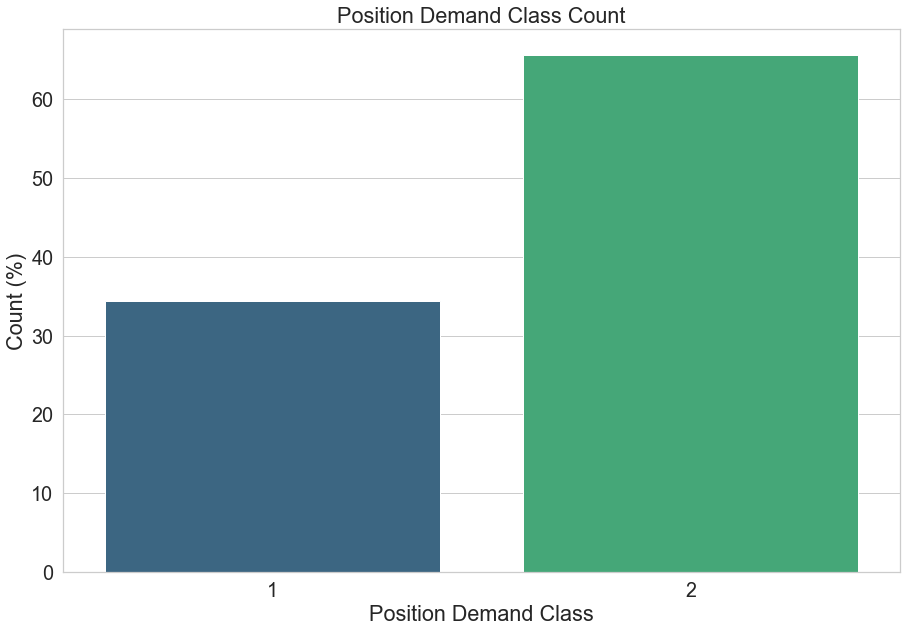

In [28]:
# visualize in a plot

plt.figure(figsize = (15, 10))
sns.barplot(x = count_demand.index, y = count_demand.values, palette = 'viridis')
plt.xlabel('Position Demand Class')
plt.ylabel('Count (%)')
plt.title('Position Demand Class Count')

plt.show()

As expected, a class boundary value of eight applicants per day provides data partitioning of 34.4% and 65.5% in Class 1 and 2, respectively.

### Replacing non-numerical with numerical categorical values

Before proceeding with modeling, we need to replace the current non-numerical categorical values with numerical categorical values in 'Job Title', 'Industry', 'Job Function', 'Metro Area', and 'Seniority Level'. We will do that both for the modeling data and the data which we will make predictions with. For predictions we will use the subset of data with an unknown number of applicants, Data B, with 'Time Posted' of one day.

In [29]:
# select data for predictions

data_pred = data_b[data_b['Time Posted'] == 1].copy()

data_pred.reset_index(inplace = True, drop = True)
data_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Job Title             966 non-null    object
 1   Industry              966 non-null    object
 2   Job Function          966 non-null    object
 3   Metro Area            966 non-null    object
 4   Education-Bachelor    966 non-null    int64 
 5   Education-Master      966 non-null    int64 
 6   Education-Doctor      966 non-null    int64 
 7   Seniority Level       966 non-null    object
 8   Relevance             966 non-null    int64 
 9   Time Posted           966 non-null    int64 
 10  Number of Applicants  966 non-null    int64 
dtypes: int64(6), object(5)
memory usage: 83.1+ KB


In [30]:
data_m.columns

Index(['Job Title', 'Industry', 'Job Function', 'Metro Area',
       'Education-Bachelor', 'Education-Master', 'Education-Doctor',
       'Seniority Level', 'Relevance', 'Time Posted', 'Number of Applicants',
       'Applicants per Day', 'Position Demand'],
      dtype='object')

In [31]:
# select appropriate features for modeling --> drop 'Time Posted', 'Number of Applicants', and 'Applicants per Day'

feat_model = ['Job Title', 'Industry', 'Job Function', 'Metro Area', 'Education-Bachelor', 'Education-Master', 
             'Education-Doctor', 'Seniority Level', 'Relevance', 'Position Demand']

data_m = data_m[feat_model]
data_m.head()

,Job Title,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Seniority Level,Relevance,Position Demand
0,Data Scientist,Internet,Engineering,ATL,0,0,0,entry,2,2
1,Data Scientist,Staffing and Recruiting,Engineering,BOS,1,1,0,entry,1,1
2,Data Scientist,Financial Services,Engineering,CHI,1,1,0,entry,2,2
3,Data Scientist,Automotive,Engineering,DAL,0,0,0,entry,2,1
4,Data Scientist,Internet,Engineering,HOU,0,0,0,entry,1,2


In [32]:
# select appropriate features for predictiong --> 
# drop 'Time Posted', 'Number of Applicants', 'Applicants per Day', 'Position Demand'

feat_pred = ['Job Title', 'Industry', 'Job Function', 'Metro Area', 'Education-Bachelor', 'Education-Master', 
             'Education-Doctor', 'Seniority Level', 'Relevance']

In [33]:
# update data_pred

data_pred = data_pred[feat_pred]
data_pred.head()

,Job Title,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Seniority Level,Relevance
0,Data Scientist,Staffing and Recruiting,Information Technology,ATL,1,1,0,entry,1
1,Data Scientist,Research,Analyst,ATL,0,0,0,entry,2
2,Data Scientist,Defense,Engineering,ATL,1,0,0,entry,3
3,Data Scientist,Staffing and Recruiting,Information Technology,ATL,1,0,0,entry,2
4,Data Scientist,Marketing and Advertising,Engineering,ATL,0,0,0,entry,3


Now, it's time to replace the non-numerical with numerical categorical values. 

Please, note that we will only use the categorical values which are present in the modeling data and eliminate the excess values in the data selected for predictions (the model cannot predict something it has not learned)!

- **Replacing 'Job Title' Values**

In [34]:
# get value count as percentages
feat = 'Job Title'

count_feat = data_m[feat].value_counts(normalize = True) * 100
print(round(count_feat, 2))

Data Scientist                 59.40
Machine Learning Engineer      12.59
Data Engineer                  11.35
Other                           4.79
Research Scientist              3.37
Manager                         3.19
Analyst                         2.30
Machine Learning Researcher     0.71
Applied Scientist               0.53
Data Science Engineer           0.35
Consultant                      0.35
Market Researcher               0.35
Software Engineer               0.18
Principal Scientist             0.18
Machine Learning Scientist      0.18
Quantitative Researcher         0.18
Name: Job Title, dtype: float64


In [35]:
print(count_feat.index)

Index(['Data Scientist', 'Machine Learning Engineer', 'Data Engineer', 'Other',
       'Research Scientist', 'Manager', 'Analyst',
       'Machine Learning Researcher', 'Applied Scientist',
       'Data Science Engineer', 'Consultant', 'Market Researcher',
       'Software Engineer', 'Principal Scientist',
       'Machine Learning Scientist', 'Quantitative Researcher'],
      dtype='object')


In [36]:
# create a dictionary to replace current non-numerical values
dict_feat = {count_feat.index[i]:(i+1) for i in range(len(count_feat))}

print(dict_feat)

# important to save the dictionary under separate name for use in the last section!
dict_title = dict_feat

{'Data Scientist': 1, 'Machine Learning Engineer': 2, 'Data Engineer': 3, 'Other': 4, 'Research Scientist': 5, 'Manager': 6, 'Analyst': 7, 'Machine Learning Researcher': 8, 'Applied Scientist': 9, 'Data Science Engineer': 10, 'Consultant': 11, 'Market Researcher': 12, 'Software Engineer': 13, 'Principal Scientist': 14, 'Machine Learning Scientist': 15, 'Quantitative Researcher': 16}


In [37]:
# Replace the current categorical values with numerical categorical values --> modeling data
data_m[feat].replace(dict_feat, inplace=True)

# check
print(data_m[feat].value_counts().index)

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 11, 10, 16, 15, 14, 13], dtype='int64')


In [38]:
# Replace the current categorical values with numerical categorical values --> prediction data
data_pred[feat].replace(dict_feat, inplace=True)

# check
print(data_pred[feat].value_counts().index)

Index([                        1,                         3,
                               2,                         4,
                               5,                         6,
                               7,                        11,
                               9,                        13,
                'Data Architect',                        10,
                              15,                        16,
       'Postdoctoral Researcher',       'Senior Researcher',
                               8,        'Senior Scientist'],
      dtype='object')


As one can see there are more job titles in this dataset. We will keep only the ones which exist in the modeling data.

In [39]:
vals_feat = data_m[feat].value_counts().index

mask_feat = data_pred[feat].isin(vals_feat)

data_pred = data_pred[mask_feat]
data_pred.reset_index(inplace = True, drop = True)

In [40]:
# check
print(data_pred[feat].value_counts().index)

Int64Index([1, 3, 2, 4, 5, 6, 7, 11, 9, 13, 15, 10, 16, 8], dtype='int64')


- **Replacing 'Industry' Values**

In [41]:
# get value count as percentages
feat = 'Industry'

count_feat = data_m[feat].value_counts(normalize = True) * 100
print(round(count_feat, 2))

Internet                               14.72
Financial Services                     13.48
Marketing and Advertising              13.30
Computer Software                       7.09
Health Care                             6.38
Biotechnology                           4.79
Management Consulting                   4.43
Information Technology and Services     4.08
Retail                                  3.01
Automotive                              2.84
Manufacturing                           2.66
Insurance                               2.48
Staffing and Recruiting                 2.48
Defense                                 2.13
Other                                   1.95
Banking                                 1.60
Network Security                        1.60
Food & Beverages                        1.24
Telecommunications                      1.06
Wellness and Fitness                    0.89
Research                                0.89
Consumer Goods                          0.89
Environmen

In [42]:
print(count_feat.index)

Index(['Internet', 'Financial Services', 'Marketing and Advertising',
       'Computer Software', 'Health Care', 'Biotechnology',
       'Management Consulting', 'Information Technology and Services',
       'Retail', 'Automotive', 'Manufacturing', 'Insurance',
       'Staffing and Recruiting', 'Defense', 'Other', 'Banking',
       'Network Security', 'Food & Beverages', 'Telecommunications',
       'Wellness and Fitness', 'Research', 'Consumer Goods', 'Environment',
       'Transportation', 'Computer Games', 'Entertainment', 'Medical Devices',
       'Supply', 'Education', 'Apparel & Fashion', 'Consumer Services',
       'Construction', 'Consumer Electronics', 'Online Media',
       'Pharmaceutical', 'Real Estate', 'Investment'],
      dtype='object')


In [43]:
# create a dictionary to replace current non-numerical values
dict_feat = {count_feat.index[i]:(i+1) for i in range(len(count_feat))}

print(dict_feat)

# important to save the dictionary under separate name for use in the last section!
dict_industry = dict_feat

{'Internet': 1, 'Financial Services': 2, 'Marketing and Advertising': 3, 'Computer Software': 4, 'Health Care': 5, 'Biotechnology': 6, 'Management Consulting': 7, 'Information Technology and Services': 8, 'Retail': 9, 'Automotive': 10, 'Manufacturing': 11, 'Insurance': 12, 'Staffing and Recruiting': 13, 'Defense': 14, 'Other': 15, 'Banking': 16, 'Network Security': 17, 'Food & Beverages': 18, 'Telecommunications': 19, 'Wellness and Fitness': 20, 'Research': 21, 'Consumer Goods': 22, 'Environment': 23, 'Transportation': 24, 'Computer Games': 25, 'Entertainment': 26, 'Medical Devices': 27, 'Supply': 28, 'Education': 29, 'Apparel & Fashion': 30, 'Consumer Services': 31, 'Construction': 32, 'Consumer Electronics': 33, 'Online Media': 34, 'Pharmaceutical': 35, 'Real Estate': 36, 'Investment': 37}


In [44]:
# Replace the current categorical values with numerical categorical values --> modeling data
data_m[feat].replace(dict_feat, inplace=True)

# check
print(data_m[feat].value_counts().index)

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 21, 22, 20, 23, 28, 24, 25, 26, 27, 29, 30, 31, 32, 33, 35,
            36, 34, 37],
           dtype='int64')


In [45]:
# Replace the current categorical values with numerical categorical values --> prediction data
data_pred[feat].replace(dict_feat, inplace=True)

# check
print(data_pred[feat].value_counts().index)

Index([               1,                2,                3,               14,
                      5,               13,                4,                6,
                     16,               12,                7,                8,
                     29,               21,                9,               11,
                     10,               17,               34,     'Accounting',
                     24,               23,               15,               32,
                     19,               35,               36,               26,
                     33,    'Engineering',               27,               22,
            'Nonprofit',               20,               28, 'Legal Services',
                     25,               30,               31,               37,
               'Energy'],
      dtype='object')


As before, we keep only the values which exist in the modeling data.

In [46]:
vals_feat = data_m[feat].value_counts().index

mask_feat = data_pred[feat].isin(vals_feat)

data_pred = data_pred[mask_feat]
data_pred.reset_index(inplace = True, drop = True)

In [47]:
# check
print(data_pred[feat].value_counts().index)

Int64Index([ 1,  2,  3, 14,  5, 13,  4,  6, 16,  7, 12,  8, 29, 21, 11,  9, 10,
            17, 34, 24, 23, 15, 19, 36, 32, 35, 26, 27, 33, 20, 22, 28, 25, 30,
            31, 37],
           dtype='int64')


- **Replacing 'Job Function' Values**

In [48]:
# get value count as percentages
feat = 'Job Function'

count_feat = data_m[feat].value_counts(normalize = True) * 100
print(round(count_feat, 2))

Engineering               49.65
Information Technology    13.65
Other                      9.22
Analyst                    6.91
Research                   6.38
Marketing                  2.13
Consulting                 1.95
Science                    1.77
Finance                    1.42
Sales                      1.42
Full-time                  1.24
Management                 0.71
Advertising                0.71
Art                        0.53
General Business           0.35
Accounting                 0.35
Business Development       0.35
Supply Chain               0.18
Education                  0.18
Manufacturing              0.18
Health Care                0.18
Customer Service           0.18
Design                     0.18
Quality Assurance          0.18
Name: Job Function, dtype: float64


In [49]:
print(count_feat.index)

Index(['Engineering', 'Information Technology', 'Other', 'Analyst', 'Research',
       'Marketing', 'Consulting', 'Science', 'Finance', 'Sales', 'Full-time',
       'Management', 'Advertising', 'Art', 'General Business', 'Accounting',
       'Business Development', 'Supply Chain', 'Education', 'Manufacturing',
       'Health Care', 'Customer Service', 'Design', 'Quality Assurance'],
      dtype='object')


In [50]:
# create a dictionary to replace current non-numerical values
dict_feat = {count_feat.index[i]:(i+1) for i in range(len(count_feat))}

print(dict_feat)

# important to save the dictionary under separate name for use in the last section!
dict_function = dict_feat

{'Engineering': 1, 'Information Technology': 2, 'Other': 3, 'Analyst': 4, 'Research': 5, 'Marketing': 6, 'Consulting': 7, 'Science': 8, 'Finance': 9, 'Sales': 10, 'Full-time': 11, 'Management': 12, 'Advertising': 13, 'Art': 14, 'General Business': 15, 'Accounting': 16, 'Business Development': 17, 'Supply Chain': 18, 'Education': 19, 'Manufacturing': 20, 'Health Care': 21, 'Customer Service': 22, 'Design': 23, 'Quality Assurance': 24}


In [51]:
# Replace the current categorical values with numerical categorical values --> modeling data
data_m[feat].replace(dict_feat, inplace=True)

# check
print(data_m[feat].value_counts().index)

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            23, 18, 19, 20, 21, 22, 24],
           dtype='int64')


In [52]:
# Replace the current categorical values with numerical categorical values --> prediction data
data_pred[feat].replace(dict_feat, inplace=True)

# check
print(data_pred[feat].value_counts().index)

Index([                1,                 2,                 3,
                       7,                 4,                 5,
                      10,                19,                 8,
                      12,                11,                 9,
                      15,                 6,                18,
                      13,                24,  'Administrative',
                      17,                20,                21,
                      14,           'Legal', 'Human Resources'],
      dtype='object')


Keep only values from modeling data.

In [53]:
vals_feat = data_m[feat].value_counts().index

mask_feat = data_pred[feat].isin(vals_feat)

data_pred = data_pred[mask_feat]
data_pred.reset_index(inplace = True, drop = True)

In [54]:
# check
print(data_pred[feat].value_counts().index)

Int64Index([1, 2, 3, 7, 4, 5, 10, 19, 8, 12, 11, 9, 6, 15, 18, 13, 24, 21, 17,
            20, 14],
           dtype='int64')


- **Replacing 'Metro Area' Values**

In [55]:
# get value count as percentages
feat = 'Metro Area'

count_feat = data_m[feat].value_counts(normalize = True) * 100
print(round(count_feat, 2))

SF     23.76
NY     15.78
BOS    10.99
SEA     7.62
CHI     7.27
DC      6.56
LA      5.14
ATL     4.08
AUS     4.08
DAL     3.19
HOU     2.30
POR     2.30
SD      2.30
PHI     1.95
PHX     1.77
NC      0.89
Name: Metro Area, dtype: float64


In [56]:
print(count_feat.index)

Index(['SF', 'NY', 'BOS', 'SEA', 'CHI', 'DC', 'LA', 'ATL', 'AUS', 'DAL', 'HOU',
       'POR', 'SD', 'PHI', 'PHX', 'NC'],
      dtype='object')


In [57]:
# create a dictionary to replace current non-numerical values
dict_feat = {count_feat.index[i]:(i+1) for i in range(len(count_feat))}

print(dict_feat)

# important to save the dictionary under separate name for use in the last section!
dict_metro = dict_feat

{'SF': 1, 'NY': 2, 'BOS': 3, 'SEA': 4, 'CHI': 5, 'DC': 6, 'LA': 7, 'ATL': 8, 'AUS': 9, 'DAL': 10, 'HOU': 11, 'POR': 12, 'SD': 13, 'PHI': 14, 'PHX': 15, 'NC': 16}


In [58]:
# Replace the current categorical values with numerical categorical values --> modeling data
data_m[feat].replace(dict_feat, inplace=True)

# check
print(data_m[feat].value_counts().index)

Int64Index([1, 2, 3, 4, 5, 6, 7, 9, 8, 10, 13, 12, 11, 14, 15, 16], dtype='int64')


In [59]:
# Replace the current categorical values with numerical categorical values --> prediction data
data_pred[feat].replace(dict_feat, inplace=True)

# check
print(data_pred[feat].value_counts().index)

Int64Index([6, 1, 2, 4, 3, 7, 5, 8, 10, 14, 15, 13, 12, 9, 11, 16], dtype='int64')


The same values exist in both datasets, so no need for elimination.

- **Replacing 'Seniority Level' Values**

In [60]:
# get value count as percentages
feat = 'Seniority Level'

count_feat = data_m[feat].value_counts(normalize = True) * 100
print(round(count_feat, 2))

senior       44.33
entry        35.82
associate    19.86
Name: Seniority Level, dtype: float64


In [61]:
print(count_feat.index)

Index(['senior', 'entry', 'associate'], dtype='object')


In [62]:
# create a dictionary to replace current non-numerical values
dict_feat = {count_feat.index[i]:(i+1) for i in range(len(count_feat))}

print(dict_feat)

# important to save the dictionary under separate name for use in the last section!
dict_seniority = dict_feat

{'senior': 1, 'entry': 2, 'associate': 3}


In [63]:
# Replace the current categorical values with numerical categorical values --> modeling data
data_m[feat].replace(dict_feat, inplace=True)

# check
print(data_m[feat].value_counts().index)

Int64Index([1, 2, 3], dtype='int64')


In [64]:
# Replace the current categorical values with numerical categorical values --> prediction data
data_pred[feat].replace(dict_feat, inplace=True)

# check
print(data_pred[feat].value_counts().index)

Int64Index([1, 3, 2], dtype='int64')


Again the same values exist in both datasets, so no need for elimination.

This concludes the data preparation for modeling and predictions. Let's check both the modeling and the predictions datasets before proceeding with modeling.

In [65]:
data_m.head()

,Job Title,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Seniority Level,Relevance,Position Demand
0,1,1,1,8,0,0,0,2,2,2
1,1,13,1,3,1,1,0,2,1,1
2,1,2,1,5,1,1,0,2,2,2
3,1,10,1,10,0,0,0,2,2,1
4,1,1,1,11,0,0,0,2,1,2


In [66]:
data_pred.head()

,Job Title,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Seniority Level,Relevance
0,1,13,2,8,1,1,0,2,1
1,1,21,4,8,0,0,0,2,2
2,1,14,1,8,1,0,0,2,3
3,1,13,2,8,1,0,0,2,2
4,1,3,1,8,0,0,0,2,3


Both datasets appear fine and we can proceed to the next stage.

## III.2 Data Modeling and Model Optimization

In our modeling, the focus is on achieving high Class 1 precision and (relatively) good recall. The reason to place emphasis on precision is that we do not want to have records belonging to Class 2 to be mis-classified as Class 1. At the same time we want to have a relatively good recall, so that we do not lose too many Class 1 records as belonging to Class 2. If the recall value is too small, the number of Class 1 postings left to work with will be very small as well.

The machine learning algorithm XGBClassifier will be used to create and optimize the model. For the optimization we will use Bayesian optimization with f1-score as a metric. The choice of f1-score as an optimization metric is perhaps the most appropriate for use in the case of unbalanced classes as in our problem.

In [67]:
# Create subsets of independent and dependent (target) variables

# independent variables
X = data_m.iloc[:, 0:9].values # includes all features, but target

# target
y = data_m.iloc[:, -1].values # target - 'Position Demand'

In [68]:
# Split into train and test subsets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

### XGBClassifier Model and Bayesian Model Optimization

- **XGBClassifier without optimization**

First, we will create an XGBClassifier model without optimization to establish a baseline for the model performance.

In [69]:
# create XGBClassifier model
from xgboost import XGBClassifier

model_0 = XGBClassifier(objective = 'binary:logistic')

In [70]:
# train and predict
model_0 = model_0.fit(X_train, y_train)

y_pred_0 = model_0.predict(X_test)

In [71]:
# evaluate model performance
from sklearn.metrics import confusion_matrix, classification_report

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_0))
print('\n')
print('Classification Report:')
print(classification_report(y_test,  y_pred_0))

Confusion Matrix:
[[17 32]
 [10 82]]


Classification Report:
              precision    recall  f1-score   support

           1       0.63      0.35      0.45        49
           2       0.72      0.89      0.80        92

    accuracy                           0.70       141
   macro avg       0.67      0.62      0.62       141
weighted avg       0.69      0.70      0.67       141



This is our baseline. The achieved Class 1 precision is relatively good, but its recall is quite low. We will perform model optimization to try to achieve better performance.

It’s worth mentioning that the seemingly large discrepancy between the precision and recall values of Class 1 and Class 2 is due to the classes imbalance - a certain number of mis-classified records is only a small portion of Class 2, but a significant portion regarding Class 1.

- **XGBClassifier with Bayesian optimization**

As an optimization metric we use f1-score which is most appropriate in the case of unbalanced classes.

In [72]:
# import hyperopt optimization packages

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn import metrics

In [73]:
# Optimization with metrics.f1_score

# create hyperparameter space to search over
space = {'max_depth': hp.choice('max_depth', np.arange(3, 15, 1, dtype = int)),
        'n_estimators': hp.choice('n_estimators', np.arange(50, 300, 10, dtype = int)),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1.0, 0.1),
        'min_child_weight': hp.choice('min_child_weight', np.arange(0, 10, 1, dtype = int)),
        'subsample': hp.quniform('subsample', 0.5, 1.0, 0.1),
        'learning_rate': hp.quniform('learning_rate', 0.1, 0.3, 0.1),
         'gamma': hp.choice('gamma', np.arange(0, 5, 1.0, dtype = float)),
         'reg_alpha': hp.choice('reg_alpha', np.arange(0, 5, 1.0, dtype = float)),
         'reg_lambda': hp.choice('reg_lambda', np.arange(0, 5, 1.0, dtype = float)),
         
        'objective':'binary:logistic'} # multiclass - use 'objective':'multi:softprob', binary - use 'objective':'binary:logistic'

# define number for max_evals
n_evals = 1000

def score_f1(params):
    model = XGBClassifier(**params, n_jobs=-1)
    
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose = False, early_stopping_rounds = 50)
    
    y_pred = model.predict(X_test)

    # metrics.f1_score
    score = -metrics.f1_score(y_test, y_pred, pos_label = 1, average = 'micro', 
                              sample_weight = None, zero_division = 'warn') # keep average = 'micro'!!!
    print(score)
    return {'loss': score, 'status': STATUS_OK}    
    
def optimize_f1(trials, space):
    
    best = fmin(score_f1, space, algo = tpe.suggest, max_evals = n_evals)
    return best

In [74]:
# Run optimization
n_evals = 1000

trials = Trials()
best_params = optimize_f1(trials, space)

-0.7375886524822695                                                                                                    
-0.6808510638297872                                                                                                    
-0.7163120567375887                                                                                                    
-0.6524822695035462                                                                                                    
-0.7021276595744681                                                                                                    
-0.7163120567375887                                                                                                    
-0.723404255319149                                                                                                     
-0.723404255319149                                                                                                     
-0.7021276595744681                     

-0.7092198581560284                                                                                                    
-0.7163120567375887                                                                                                    
-0.7021276595744681                                                                                                    
-0.7304964539007093                                                                                                    
-0.6524822695035462                                                                                                    
-0.7021276595744681                                                                                                    
-0.7163120567375887                                                                                                    
-0.7375886524822695                                                                                                    
-0.7163120567375887                     

-0.7517730496453902                                                                                                    
-0.7092198581560284                                                                                                    
-0.7304964539007093                                                                                                    
-0.7375886524822695                                                                                                    
-0.7021276595744681                                                                                                    
-0.7517730496453902                                                                                                    
-0.6950354609929078                                                                                                    
-0.7092198581560284                                                                                                    
-0.6950354609929078                     

-0.723404255319149                                                                                                     
-0.7163120567375887                                                                                                    
-0.7375886524822695                                                                                                    
-0.7021276595744681                                                                                                    
-0.723404255319149                                                                                                     
-0.7163120567375887                                                                                                    
-0.7021276595744681                                                                                                    
-0.7517730496453902                                                                                                    
-0.723404255319149                      

-0.7304964539007093                                                                                                    
-0.7588652482269503                                                                                                    
-0.7021276595744681                                                                                                    
-0.7517730496453902                                                                                                    
-0.7021276595744681                                                                                                    
-0.723404255319149                                                                                                     
-0.7163120567375887                                                                                                    
-0.7588652482269503                                                                                                    
-0.7163120567375887                     

-0.7588652482269503                                                                                                    
-0.7163120567375887                                                                                                    
-0.7517730496453902                                                                                                    
-0.6595744680851063                                                                                                    
-0.7021276595744681                                                                                                    
-0.7163120567375887                                                                                                    
-0.7092198581560284                                                                                                    
-0.723404255319149                                                                                                     
-0.7304964539007093                     

-0.7588652482269503                                                                                                    
-0.7163120567375887                                                                                                    
-0.7588652482269503                                                                                                    
-0.723404255319149                                                                                                     
-0.7588652482269503                                                                                                    
-0.7446808510638298                                                                                                    
-0.723404255319149                                                                                                     
-0.7092198581560284                                                                                                    
-0.7021276595744681                     

-0.7021276595744681                                                                                                    
-0.7304964539007093                                                                                                    
-0.7304964539007093                                                                                                    
-0.7588652482269503                                                                                                    
-0.7304964539007093                                                                                                    
-0.7446808510638298                                                                                                    
-0.7021276595744681                                                                                                    
-0.7730496453900709                                                                                                    
-0.7021276595744681                     

-0.7730496453900709                                                                                                    
-0.7021276595744681                                                                                                    
-0.723404255319149                                                                                                     
-0.7446808510638298                                                                                                    
-0.7021276595744681                                                                                                    
-0.6595744680851063                                                                                                    
-0.7517730496453902                                                                                                    
-0.7730496453900709                                                                                                    
-0.7446808510638298                     

-0.7375886524822695                                                                                                    
-0.7446808510638298                                                                                                    
-0.7092198581560284                                                                                                    
-0.7446808510638298                                                                                                    
-0.7021276595744681                                                                                                    
-0.7092198581560284                                                                                                    
-0.6950354609929078                                                                                                    
-0.7730496453900709                                                                                                    
-0.7730496453900709                     

-0.7021276595744681                                                                                                    
-0.723404255319149                                                                                                     
-0.7375886524822695                                                                                                    
-0.7021276595744681                                                                                                    
-0.7021276595744681                                                                                                    
-0.7588652482269503                                                                                                    
-0.7092198581560284                                                                                                    
-0.7021276595744681                                                                                                    
-0.6950354609929078                     

-0.7517730496453902                                                                                                    
-0.6879432624113475                                                                                                    
-0.7021276595744681                                                                                                    
-0.723404255319149                                                                                                     
-0.7092198581560284                                                                                                    
-0.7446808510638298                                                                                                    
-0.7517730496453902                                                                                                    
-0.6950354609929078                                                                                                    
-0.7021276595744681                     

-0.7446808510638298                                                                                                    
-0.7730496453900709                                                                                                    
-0.7446808510638298                                                                                                    
-0.7163120567375887                                                                                                    
-0.7304964539007093                                                                                                    
-0.7021276595744681                                                                                                    
-0.7092198581560284                                                                                                    
-0.7659574468085105                                                                                                    
-0.7730496453900709                     

-0.7446808510638298                                                                                                    
-0.723404255319149                                                                                                     
-0.7375886524822695                                                                                                    
-0.723404255319149                                                                                                     
-0.7446808510638298                                                                                                    
-0.723404255319149                                                                                                     
-0.723404255319149                                                                                                     
-0.7021276595744681                                                                                                    
-0.7021276595744681                     

-0.723404255319149                                                                                                     
-0.7304964539007093                                                                                                    
-0.7446808510638298                                                                                                    
-0.7092198581560284                                                                                                    
-0.7730496453900709                                                                                                    
-0.6879432624113475                                                                                                    
-0.723404255319149                                                                                                     
-0.7304964539007093                                                                                                    
-0.7375886524822695                     

In [75]:
# get best parameters
space_eval(space, best_params)

{'colsample_bytree': 1.0,
 'gamma': 1.0,
 'learning_rate': 0.30000000000000004,
 'max_depth': 3,
 'min_child_weight': 6,
 'n_estimators': 180,
 'objective': 'binary:logistic',
 'reg_alpha': 0.0,
 'reg_lambda': 3.0,
 'subsample': 0.5}

In [76]:
# Create optimized model

model_opt = XGBClassifier(colsample_bytree = 1.0, 
                          gamma = 1.0, 
                          learning_rate = 0.3, 
                          max_depth = 3, 
                          min_child_weight = 6, 
                          n_estimators = 180, 
                          reg_alpha = 0.0, 
                          reg_lambda = 3.0, 
                          subsample = 0.5,  
                          objective = 'binary:logistic')

In [77]:
# train and predict with opt model
model_opt = model_opt.fit(X_train, y_train)

y_pred_opt = model_opt.predict(X_test)

In [78]:
# evaluate model performance

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_opt))
print('\n')
print('Classification Report:')
print(classification_report(y_test,  y_pred_opt))

Confusion Matrix:
[[22 27]
 [12 80]]


Classification Report:
              precision    recall  f1-score   support

           1       0.65      0.45      0.53        49
           2       0.75      0.87      0.80        92

    accuracy                           0.72       141
   macro avg       0.70      0.66      0.67       141
weighted avg       0.71      0.72      0.71       141



The optimized model achieved better Class 1 precision and recall. We would like to note, however, that since Class 1 is the minority class small changes in absolute terms in the predicted numbers of points belonging to both classes would result in significant variances in the Class 1 prediction scores percentage wise.

That's why, in order to establish a confidence interval in our predictions, we will run the optimization process ten times and will record the resulting Class 1 precision and recall for each run. In addition, we will record the overall f1-score to keep track on possible issues with the model convergence.

### Establishing Class 1 Predictions Confidence Interval

As mentioned above, we will run the optimization process ten times and record the model's performance in terms of Class 1 precision and recall, and overall f-1 score.

We already have the first record from the result above. Thus, we need to perform nine additional optimization runs.

In [119]:
# 1) Run optimization
n_evals = 1000

trials = Trials()
best_params = optimize_f1(trials, space)

-0.7375886524822695                                                                                                    
-0.6808510638297872                                                                                                    
-0.7304964539007093                                                                                                    
-0.6950354609929078                                                                                                    
-0.6950354609929078                                                                                                    
-0.6879432624113475                                                                                                    
-0.7021276595744681                                                                                                    
-0.7304964539007093                                                                                                    
-0.7517730496453902                     

-0.7517730496453902                                                                                                    
-0.7517730496453902                                                                                                    
-0.7517730496453902                                                                                                    
-0.6950354609929078                                                                                                    
-0.6808510638297872                                                                                                    
-0.6950354609929078                                                                                                    
-0.6879432624113475                                                                                                    
-0.7163120567375887                                                                                                    
-0.6879432624113475                     

-0.7517730496453902                                                                                                    
-0.7092198581560284                                                                                                    
-0.7588652482269503                                                                                                    
-0.7588652482269503                                                                                                    
-0.723404255319149                                                                                                     
-0.7517730496453902                                                                                                    
-0.7588652482269503                                                                                                    
-0.7304964539007093                                                                                                    
-0.7021276595744681                     

-0.7588652482269503                                                                                                    
-0.7446808510638298                                                                                                    
-0.7304964539007093                                                                                                    
-0.6879432624113475                                                                                                    
-0.6808510638297872                                                                                                    
-0.723404255319149                                                                                                     
-0.7304964539007093                                                                                                    
-0.7092198581560284                                                                                                    
-0.7446808510638298                     

-0.7163120567375887                                                                                                    
-0.723404255319149                                                                                                     
-0.7375886524822695                                                                                                    
-0.7375886524822695                                                                                                    
-0.7446808510638298                                                                                                    
-0.7659574468085105                                                                                                    
-0.7446808510638298                                                                                                    
-0.7659574468085105                                                                                                    
-0.6950354609929078                     

-0.6879432624113475                                                                                                    
-0.7659574468085105                                                                                                    
-0.7092198581560284                                                                                                    
-0.7588652482269503                                                                                                    
-0.6950354609929078                                                                                                    
-0.7446808510638298                                                                                                    
-0.7659574468085105                                                                                                    
-0.7092198581560284                                                                                                    
-0.723404255319149                      

-0.7659574468085105                                                                                                    
-0.7304964539007093                                                                                                    
-0.7659574468085105                                                                                                    
-0.7659574468085105                                                                                                    
-0.7659574468085105                                                                                                    
-0.7659574468085105                                                                                                    
-0.7659574468085105                                                                                                    
-0.7659574468085105                                                                                                    
-0.7659574468085105                     

-0.7021276595744681                                                                                                    
-0.6879432624113475                                                                                                    
-0.7021276595744681                                                                                                    
-0.7659574468085105                                                                                                    
-0.7304964539007093                                                                                                    
-0.7021276595744681                                                                                                    
-0.723404255319149                                                                                                     
-0.723404255319149                                                                                                     
-0.7588652482269503                     

-0.7659574468085105                                                                                                    
-0.7446808510638298                                                                                                    
-0.7375886524822695                                                                                                    
-0.6950354609929078                                                                                                    
-0.7375886524822695                                                                                                    
-0.7021276595744681                                                                                                    
-0.6879432624113475                                                                                                    
-0.7446808510638298                                                                                                    
-0.6950354609929078                     

-0.7659574468085105                                                                                                    
-0.723404255319149                                                                                                     
-0.7021276595744681                                                                                                    
-0.7375886524822695                                                                                                    
-0.7021276595744681                                                                                                    
-0.7021276595744681                                                                                                    
-0.7021276595744681                                                                                                    
-0.7659574468085105                                                                                                    
-0.7446808510638298                     

-0.7446808510638298                                                                                                    
-0.6950354609929078                                                                                                    
-0.7446808510638298                                                                                                    
-0.7517730496453902                                                                                                    
-0.7375886524822695                                                                                                    
-0.7021276595744681                                                                                                    
-0.6950354609929078                                                                                                    
-0.7092198581560284                                                                                                    
-0.7092198581560284                     

-0.6950354609929078                                                                                                    
-0.7446808510638298                                                                                                    
-0.7021276595744681                                                                                                    
-0.6950354609929078                                                                                                    
-0.7659574468085105                                                                                                    
-0.7304964539007093                                                                                                    
-0.7021276595744681                                                                                                    
-0.7163120567375887                                                                                                    
-0.7517730496453902                     

-0.7375886524822695                                                                                                    
-0.7163120567375887                                                                                                    
-0.7659574468085105                                                                                                    
-0.7659574468085105                                                                                                    
-0.6950354609929078                                                                                                    
-0.7304964539007093                                                                                                    
-0.7517730496453902                                                                                                    
-0.7021276595744681                                                                                                    
-0.7092198581560284                     

-0.7375886524822695                                                                                                    
-0.7375886524822695                                                                                                    
-0.7375886524822695                                                                                                    
-0.7163120567375887                                                                                                    
-0.7021276595744681                                                                                                    
-0.7304964539007093                                                                                                    
-0.7163120567375887                                                                                                    
-0.7588652482269503                                                                                                    
-0.6950354609929078                     

-0.6524822695035462                                                                                                    
-0.7659574468085105                                                                                                    
-0.7659574468085105                                                                                                    
-0.6950354609929078                                                                                                    
-0.7163120567375887                                                                                                    
-0.7659574468085105                                                                                                    
-0.7659574468085105                                                                                                    
-0.7588652482269503                                                                                                    
-0.7092198581560284                     

In [120]:
# 2) Get best parameters
space_eval(space, best_params)

{'colsample_bytree': 0.9,
 'gamma': 3.0,
 'learning_rate': 0.30000000000000004,
 'max_depth': 3,
 'min_child_weight': 3,
 'n_estimators': 290,
 'objective': 'binary:logistic',
 'reg_alpha': 1.0,
 'reg_lambda': 0.0,
 'subsample': 0.6000000000000001}

In [121]:
# 3) Create optimized model (as a good practice save the model parameters from different runs in a text file for later use)

model_opt = XGBClassifier(colsample_bytree = 0.9, 
                          gamma = 3.0, 
                          learning_rate = 0.3, 
                          max_depth = 3, 
                          min_child_weight = 3, 
                          n_estimators = 290, 
                          reg_alpha = 1.0, 
                          reg_lambda = 0.0, 
                          subsample = 0.6,  
                          objective = 'binary:logistic')

In [122]:
# 4) Train and predict with opt model
model_opt = model_opt.fit(X_train, y_train)

y_pred_opt = model_opt.predict(X_test)

In [123]:
# 5) Evaluate model performance

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_opt))
print('\n')
print('Classification Report:')
print(classification_report(y_test,  y_pred_opt))

Confusion Matrix:
[[19 30]
 [11 81]]


Classification Report:
              precision    recall  f1-score   support

           1       0.63      0.39      0.48        49
           2       0.73      0.88      0.80        92

    accuracy                           0.71       141
   macro avg       0.68      0.63      0.64       141
weighted avg       0.70      0.71      0.69       141



### Optimization performance records: 
Class 1 precision, Class 1 recall, Overall f1-score

- Run  1: 0.65, 0.45, 0.72
- Run  2: 0.75, 0.43, 0.75
- Run  3: 0.66, 0.47, 0.73
- Run  4: 0.66, 0.43, 0.72
- Run  5: 0.50, 0.41, 0.65
- Run  6: 0.66, 0.39, 0.72
- Run  7: 0.70, 0.47, 0.74
- Run  8: 0.66, 0.43, 0.72
- Run  9: 0.62, 0.43, 0.71
- Run 10: 0.63, 0.39, 0.71

**Average: 0.65, 0.43, 0.72**

The overall f1-score shows little variations which indicates good model convergence during optimization. The Class 1 precision and recall show greater variations as expected. Since the performance of the model resulting from Optimization run 8 is closest to the average values this is the model we will use for predictions.

## III.3 Predictions with Unknown Data and Analysis of Results

- **Predictions**

In [124]:
# recall prediction data, data_pred

data_pred.head()

,Job Title,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Seniority Level,Relevance
0,1,13,2,8,1,1,0,2,1
1,1,21,4,8,0,0,0,2,2
2,1,14,1,8,1,0,0,2,3
3,1,13,2,8,1,0,0,2,2
4,1,3,1,8,0,0,0,2,3


In [125]:
X_pred = data_pred.values

In [126]:
# Select the model for predictions

model_pred = XGBClassifier(colsample_bytree = 1.0, 
                          gamma = 1.0, 
                          learning_rate = 0.2, 
                          max_depth = 4, 
                          min_child_weight = 6, 
                          n_estimators = 100, 
                          reg_alpha = 0.0, 
                          reg_lambda = 1.0, 
                          subsample = 0.6,  
                          objective = 'binary:logistic')

In [127]:
# train with entire modeling dataset

model_pred = model_pred.fit(X, y)

In [128]:
# make predictions

y_pred = model_pred.predict(X_pred)

- **Analysis of Prediction Results**

#### Percentage of data points predicted in Class 1

This is something we can easily obtain from the predictions and compare with the expected value from the modeling data, data_m.

In [130]:
print('Percentage of predicted Class 1 data points from Data B with Time Posted of 1: ', 
      round(len(y_pred[y_pred == 1]) * 100 / len(y_pred), 2))

Percentage of predicted Class 1 data points from Data B with Time Posted of 1:  32.59


If we recall, the Class 1 points in the modeling data represented 34.4%. Therefore, in regards with this metric, the predictions from Data B are consistent with the expectations set from the modeling data.

#### Comparison of features composition by classes: predictions vs. modeling data

We need to add the predicted classes to the data used for predictions. After that, we will examine certain future values compositions from the modeling data and that used in predictions in order to establish whether the predictions are consistent with our expectations.

- Add predicted classes to prediction data

In [131]:
data_pred['Position Demand'] = y_pred

data_pred.head(10)

,Job Title,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Seniority Level,Relevance,Position Demand
0,1,13,2,8,1,1,0,2,1,1
1,1,21,4,8,0,0,0,2,2,2
2,1,14,1,8,1,0,0,2,3,1
3,1,13,2,8,1,0,0,2,2,1
4,1,3,1,8,0,0,0,2,3,2
5,3,7,2,8,1,1,1,2,2,2
6,1,2,1,8,0,0,0,2,1,2
7,1,23,8,8,1,1,0,2,2,1
8,3,3,2,9,1,1,0,2,2,1
9,2,6,5,3,1,1,0,2,2,2


We have added the predicted classes to the data used for predictions. However, as we can see the data contains the numerical categorical values used for modeling. Therefore we need to recover the original features non-numerical values.

- Recover the original feature values from the modeling data, data_m, and the prediction data, data_pred.

    - Restore original 'Job Title' values

In [132]:
print(dict_title)

{'Data Scientist': 1, 'Machine Learning Engineer': 2, 'Data Engineer': 3, 'Other': 4, 'Research Scientist': 5, 'Manager': 6, 'Analyst': 7, 'Machine Learning Researcher': 8, 'Applied Scientist': 9, 'Data Science Engineer': 10, 'Consultant': 11, 'Market Researcher': 12, 'Software Engineer': 13, 'Principal Scientist': 14, 'Machine Learning Scientist': 15, 'Quantitative Researcher': 16}


In [133]:
# deine a function to convert back the numerical values to their original values

data_feat = 'Job Title'
dict_feat = dict_title # this is where we use the previously saved dictionaries

def get_initial_values(data, data_feat, dict_feat):
    dict_keys = list(dict_feat.keys())
    dict_vals = list(dict_feat.values())
    
    for i in range(len(data)):
        val = data[data_feat][i]
        data[data_feat][i] = dict_keys[dict_vals.index(val)]

In [134]:
# get the original feature values
data_feat = 'Job Title'
dict_feat = dict_title

# modeling data
get_initial_values(data_m, data_feat, dict_feat)

# prediction data
get_initial_values(data_pred, data_feat, dict_feat)

    - Restore original 'Industry' values

In [135]:
print(dict_industry)

{'Internet': 1, 'Financial Services': 2, 'Marketing and Advertising': 3, 'Computer Software': 4, 'Health Care': 5, 'Biotechnology': 6, 'Management Consulting': 7, 'Information Technology and Services': 8, 'Retail': 9, 'Automotive': 10, 'Manufacturing': 11, 'Insurance': 12, 'Staffing and Recruiting': 13, 'Defense': 14, 'Other': 15, 'Banking': 16, 'Network Security': 17, 'Food & Beverages': 18, 'Telecommunications': 19, 'Wellness and Fitness': 20, 'Research': 21, 'Consumer Goods': 22, 'Environment': 23, 'Transportation': 24, 'Computer Games': 25, 'Entertainment': 26, 'Medical Devices': 27, 'Supply': 28, 'Education': 29, 'Apparel & Fashion': 30, 'Consumer Services': 31, 'Construction': 32, 'Consumer Electronics': 33, 'Online Media': 34, 'Pharmaceutical': 35, 'Real Estate': 36, 'Investment': 37}


In [136]:
# get the original feature values
data_feat = 'Industry'
dict_feat = dict_industry

# modeling data
get_initial_values(data_m, data_feat, dict_feat)

# prediction data
get_initial_values(data_pred, data_feat, dict_feat)

    - Restore original 'Job Function' values

In [137]:
print(dict_function)

{'Engineering': 1, 'Information Technology': 2, 'Other': 3, 'Analyst': 4, 'Research': 5, 'Marketing': 6, 'Consulting': 7, 'Science': 8, 'Finance': 9, 'Sales': 10, 'Full-time': 11, 'Management': 12, 'Advertising': 13, 'Art': 14, 'General Business': 15, 'Accounting': 16, 'Business Development': 17, 'Supply Chain': 18, 'Education': 19, 'Manufacturing': 20, 'Health Care': 21, 'Customer Service': 22, 'Design': 23, 'Quality Assurance': 24}


In [138]:
# get the original feature values
data_feat = 'Job Function'
dict_feat = dict_function

# modeling data
get_initial_values(data_m, data_feat, dict_feat)

# prediction data
get_initial_values(data_pred, data_feat, dict_feat)

    - Restore original 'Metro Area' values

In [139]:
print(dict_metro)

{'SF': 1, 'NY': 2, 'BOS': 3, 'SEA': 4, 'CHI': 5, 'DC': 6, 'LA': 7, 'ATL': 8, 'AUS': 9, 'DAL': 10, 'HOU': 11, 'POR': 12, 'SD': 13, 'PHI': 14, 'PHX': 15, 'NC': 16}


In [140]:
# get the original feature values
data_feat = 'Metro Area'
dict_feat = dict_metro

# modeling data
get_initial_values(data_m, data_feat, dict_feat)

# prediction data
get_initial_values(data_pred, data_feat, dict_feat)

    - Restore original 'Seniority Level' values

In [141]:
print(dict_seniority)

{'senior': 1, 'entry': 2, 'associate': 3}


In [142]:
# get the original feature values
data_feat = 'Seniority Level'
dict_feat = dict_seniority

# modeling data
get_initial_values(data_m, data_feat, dict_feat)

# prediction data
get_initial_values(data_pred, data_feat, dict_feat)

    - Check the restored feature values in both datasets

In [143]:
# modeling data
data_m.head()

,Job Title,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Seniority Level,Relevance,Position Demand
0,Data Scientist,Internet,Engineering,ATL,0,0,0,entry,2,2
1,Data Scientist,Staffing and Recruiting,Engineering,BOS,1,1,0,entry,1,1
2,Data Scientist,Financial Services,Engineering,CHI,1,1,0,entry,2,2
3,Data Scientist,Automotive,Engineering,DAL,0,0,0,entry,2,1
4,Data Scientist,Internet,Engineering,HOU,0,0,0,entry,1,2


In [144]:
# prediction data
data_pred.head()

,Job Title,Industry,Job Function,Metro Area,Education-Bachelor,Education-Master,Education-Doctor,Seniority Level,Relevance,Position Demand
0,Data Scientist,Staffing and Recruiting,Information Technology,ATL,1,1,0,entry,1,1
1,Data Scientist,Research,Analyst,ATL,0,0,0,entry,2,2
2,Data Scientist,Defense,Engineering,ATL,1,0,0,entry,3,1
3,Data Scientist,Staffing and Recruiting,Information Technology,ATL,1,0,0,entry,2,1
4,Data Scientist,Marketing and Advertising,Engineering,ATL,0,0,0,entry,3,2


We have successfully restored the original feature values in the datasets used for modeling and predictions. Please, note that these are different datasets, so one should not expect to see the same feature values.

Next, we will examine if the features composition in terms of predicted classes is consistent when comparing the modeling data to the prediction results. Since these are different datasets, the test here is not a measure of successful predictions. Consistent results will give us some degree of confidence in our predictions. On the other hand, extreme discrepancies should raise a red flag prompting a deeper investigation of our modeling and predictions procedures. 

For this comparison test, we will use 'Job Title' which has similar composition in both Data A and Data B (refer to EDA Section comparison between the two datasets).

- **'Job Title' Composition Comparison**

    - Overall 'Job Title' Count

In [145]:
# define a function to plot the value count of different features for any dataset - same function used in Section II

data_feat = 'Job Title'
data_name = 'Modeling Data' # data_name will be used as a legend in the plot
plt_pts = 25

fig_size_x = 12
fig_size_y = 15

x_max = 100
d_x = 10

# define function
def plot_feat_count(data, data_feat, data_name, plt_pts, fig_size_x, fig_size_y, x_max, d_x):
    
    plt.figure(figsize = (fig_size_x, fig_size_y))
    sns.barplot(x = count_feat.iloc[0:plt_pts].values, y = count_feat.iloc[0:plt_pts].index, palette = 'viridis')
    plt.xlim(0, x_max)
    plt.xticks(np.arange(0, x_max + d_x , d_x))
    plt.xlabel('Count (%)')
    plt.title(data_feat + ' Count as Percentage of All Data: ' + data_name, pad = 20)
    plt.show()

In [146]:
# get and print feature value count for df_m_c1

data = data_m
data_feat = 'Job Title'
count_feat = data[data_feat].value_counts(normalize = True) * 100

print(count_feat)
print('\n')
print(data_feat + ' - total number of values: ', len(count_feat))

Data Scientist                 59.397163
Machine Learning Engineer      12.588652
Data Engineer                  11.347518
Other                           4.787234
Research Scientist              3.368794
Manager                         3.191489
Analyst                         2.304965
Machine Learning Researcher     0.709220
Applied Scientist               0.531915
Data Science Engineer           0.354610
Consultant                      0.354610
Market Researcher               0.354610
Software Engineer               0.177305
Principal Scientist             0.177305
Machine Learning Scientist      0.177305
Quantitative Researcher         0.177305
Name: Job Title, dtype: float64


Job Title - total number of values:  16


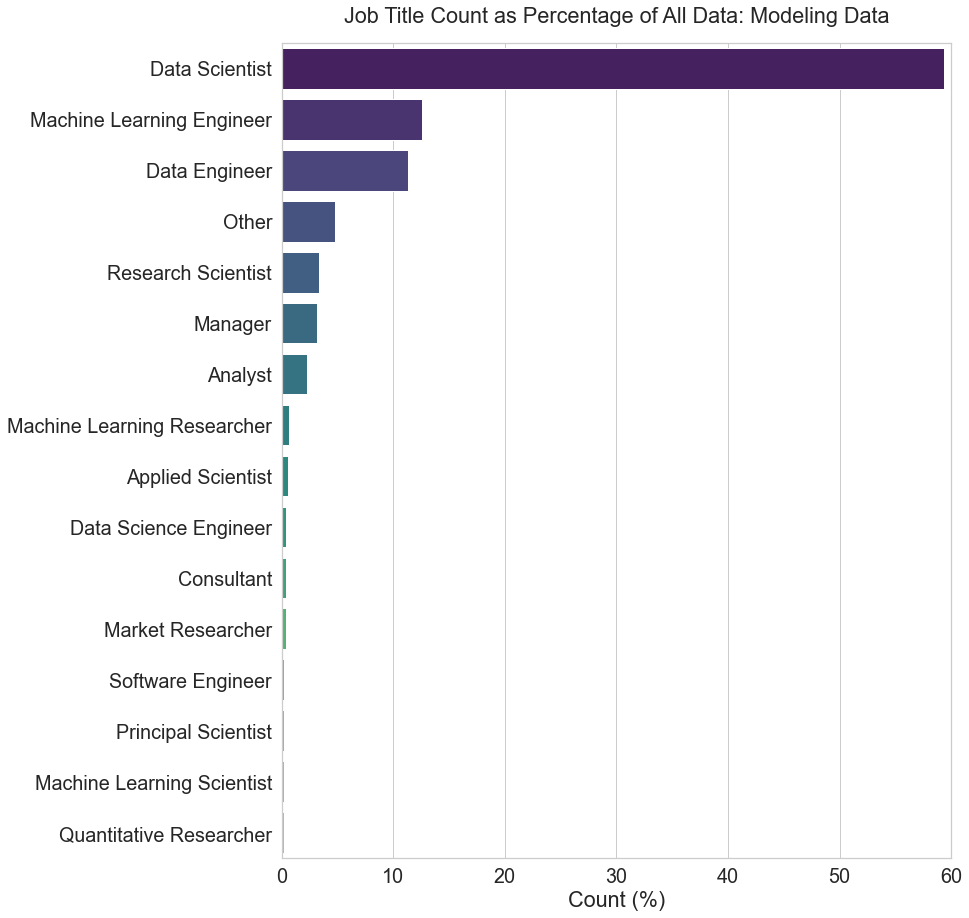

In [147]:
# plot all
plt_pts = len(count_feat)
x_max = 60
d_x = 10
data_name = 'Modeling Data'
plot_feat_count(data, data_feat, data_name, plt_pts, fig_size_x, fig_size_y, x_max, d_x)

In [148]:
# get and print 'Job Title' value count for data_pred

data = data_pred

count_feat = data[data_feat].value_counts(normalize = True) * 100

print(count_feat)
print('\n')
print(data_feat + ' - total number of values: ', len(count_feat))

Data Scientist                 53.205128
Data Engineer                  18.910256
Machine Learning Engineer      10.470085
Other                           6.837607
Research Scientist              2.564103
Manager                         1.923077
Analyst                         1.495726
Consultant                      1.282051
Applied Scientist               1.175214
Software Engineer               0.854701
Data Science Engineer           0.427350
Machine Learning Scientist      0.427350
Quantitative Researcher         0.320513
Machine Learning Researcher     0.106838
Name: Job Title, dtype: float64


Job Title - total number of values:  14


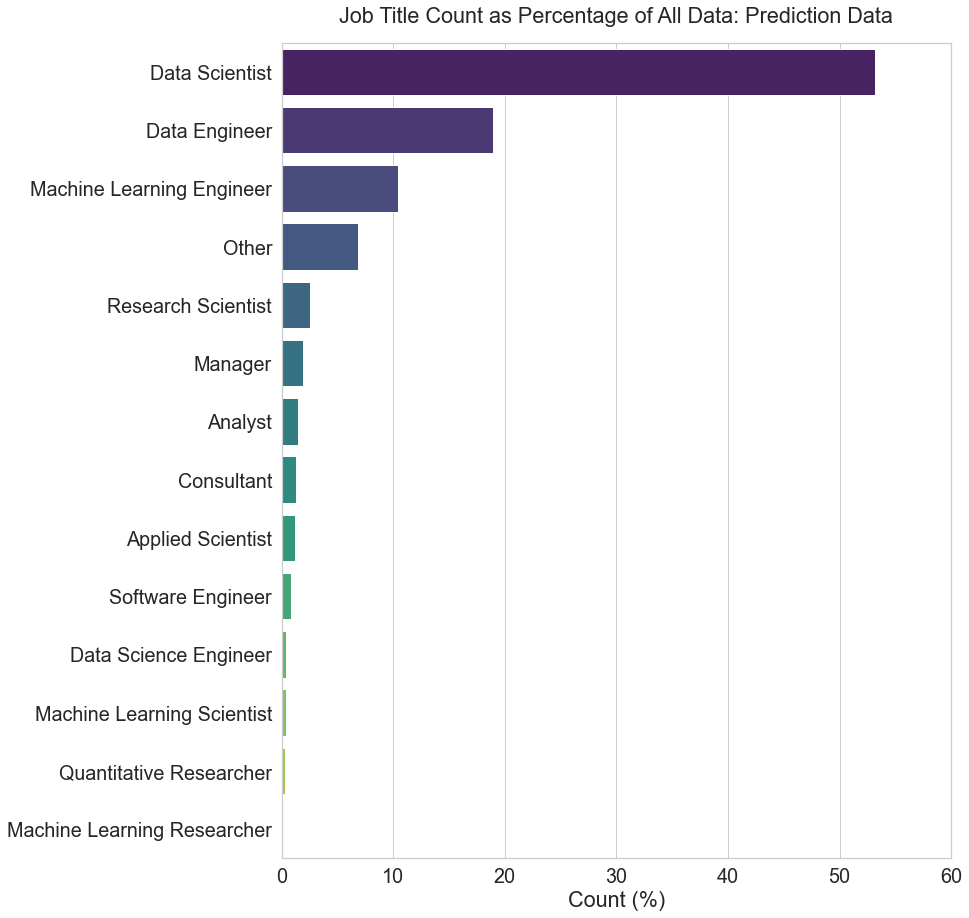

In [149]:
# plot all
plt_pts = len(count_feat)
x_max = 60
data_name = 'Prediction Data'
plot_feat_count(data, data_feat, data_name, plt_pts, fig_size_x, fig_size_y, x_max, d_x)

We note that the counts for the top seven titles which represent the majority of data in both datasets are very similar. The most notable exceptions are the positions of the titles 'Data Engineer' and 'Machine Learning Engineer' which are swapped in the two datasets.

    - 'Job Title' Class 1 Postings Count
    
Here we will compare the proportion of data belonging to Class 1 for each job title as a percentage of the records with this particular job title. For most adequate comparison, we will compare only the job titles common for both datasets.

In [150]:
data = data_m

print(data[data_feat].value_counts().index)

Index(['Data Scientist', 'Machine Learning Engineer', 'Data Engineer', 'Other',
       'Research Scientist', 'Manager', 'Analyst',
       'Machine Learning Researcher', 'Applied Scientist',
       'Data Science Engineer', 'Consultant', 'Market Researcher',
       'Software Engineer', 'Principal Scientist',
       'Machine Learning Scientist', 'Quantitative Researcher'],
      dtype='object')


In [151]:
data = data_pred

print(data[data_feat].value_counts().index)

Index(['Data Scientist', 'Data Engineer', 'Machine Learning Engineer', 'Other',
       'Research Scientist', 'Manager', 'Analyst', 'Consultant',
       'Applied Scientist', 'Software Engineer', 'Data Science Engineer',
       'Machine Learning Scientist', 'Quantitative Researcher',
       'Machine Learning Researcher'],
      dtype='object')


In [152]:
# select common titles

common_titles = []

titles_m = data_m[data_feat].value_counts().index
titles_pred = data_pred[data_feat].value_counts().index


for item in titles_m:
    if item in titles_pred:
        common_titles.append(item)
        
print(common_titles)

['Data Scientist', 'Machine Learning Engineer', 'Data Engineer', 'Other', 'Research Scientist', 'Manager', 'Analyst', 'Machine Learning Researcher', 'Applied Scientist', 'Data Science Engineer', 'Consultant', 'Software Engineer', 'Machine Learning Scientist', 'Quantitative Researcher']


In [153]:
# define a function to plot the percentage of data points in Class 1 relative to all points with a particular feature value

class_feat = 'Position Demand'
class_val = 1
feat_vals = common_titles

def plot_feat_count_c1(data, data_feat, data_name, feat_vals, class_feat, class_val, fig_size_x, fig_size_y, x_max, d_x):
    
    class_count = []
    
    for item in feat_vals:
        class_count.append(len(data[(data[data_feat] == item) & (data[class_feat] == class_val)]) * 100 / len(data[data[data_feat] == item]))
    
    plt.figure(figsize = (fig_size_x, fig_size_y))
    sns.barplot(x = class_count, y = feat_vals, palette = 'viridis')
    plt.xlim(0, x_max)
    plt.xticks(np.arange(0, x_max + d_x , d_x))
    plt.xlabel('Count (%)')
    plt.title('Percentage of Postings in Class ' + str(class_val) + ' for Particular ' + data_feat + ' : ' + data_name, pad = 20)
    plt.show()

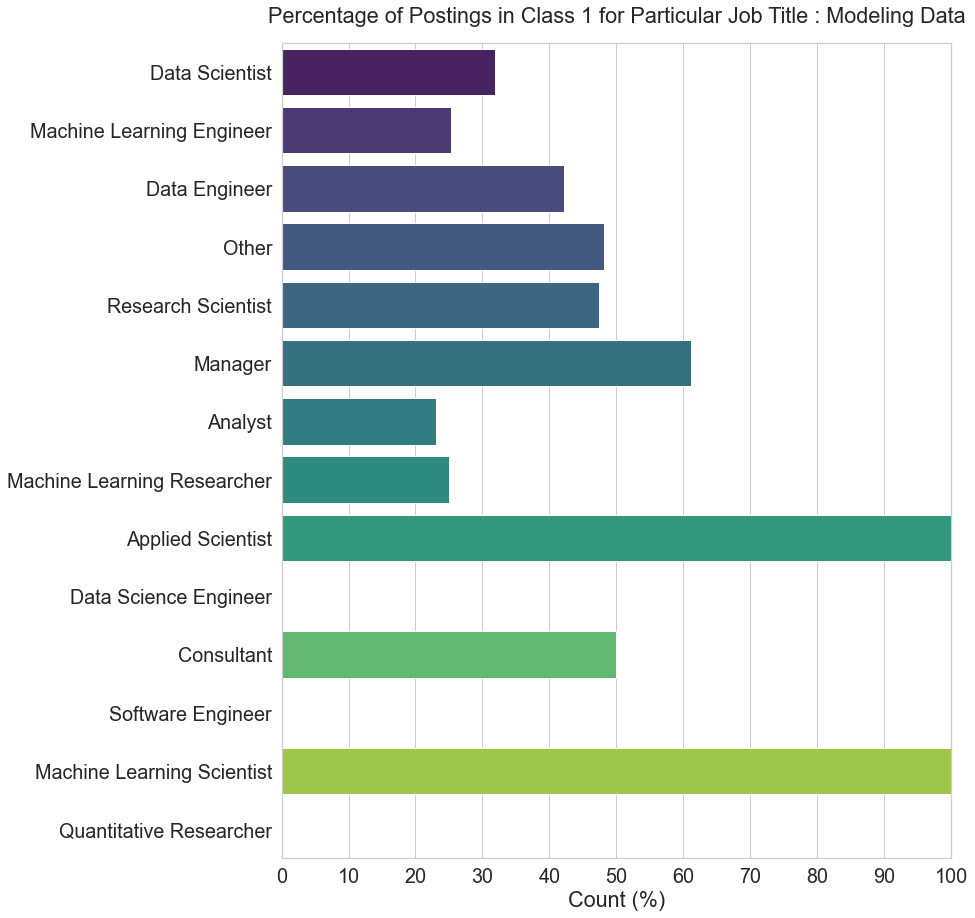

In [154]:
# plot Class 1 percentage for job titles in data_m
data = data_m
data_feat = 'Job Title'
data_name = 'Modeling Data'

x_max = 100

plot_feat_count_c1(data, data_feat, data_name, feat_vals, class_feat, class_val, fig_size_x, fig_size_y, x_max, d_x)

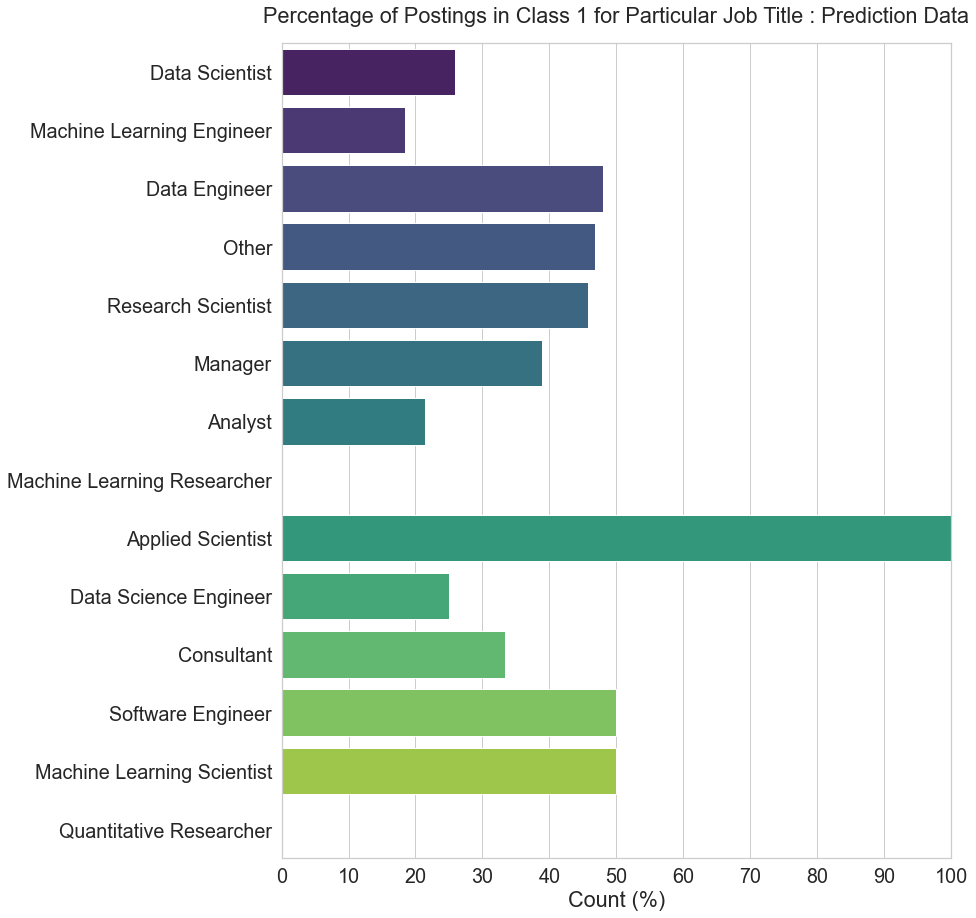

In [155]:
# plot Class 1 percentage for job titles in data_pred
data = data_pred
data_name = 'Prediction Data'

plot_feat_count_c1(data, data_feat, data_name, feat_vals, class_feat, class_val, fig_size_x, fig_size_y, x_max, d_x)

When comparing both plots, one can see that, except some small discrepancies, the percentage of Class 1 postings for different job titles is very similar between the two datasets. This is particularly true for the top five titles. This result increases our confidence in the validity of the predictions.